# Chatbot using RNN's in PyTorch

In this project, we use RNN's to create a seq2seq model and train a machine to interpret user input and develop a response. There are several steps to this, much of it is getting the data in the right format, setting up our encoder and decoder model, then training the model and running it and talking to the bot. The steps are: 

1. Data Preprocessing
2. Prepare data for ML model
3. Defining the model
4. Training and running the model

This project follows a tutorial on the pytoch.org website. Another resource I used was a youtube video that explains each step of the RNN's in more detail. This video is on the Free Code Camp youtube page.

In [191]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools

In [192]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

In [193]:
device

device(type='cpu')

## Part 1: Data Preprocessing

The first step is to format our data so that the computer can interpret what it is, and how we want to read and manipulate it. The data is from the cornell movie dialogs corpus, a dataset of text files that contain information of coversations from over 600 movies. What we are going to do is use that dataset to accurately predict the response that a person would have to a particular phrase (what the user says)

In [194]:
lines_filepath = os.path.join("cornell movie-dialogs corpus", "movie_lines.txt")
conv_filepath = os.path.join("cornell movie-dialogs corpus", "movie_conversations.txt")

In [195]:
# Visualize some lines
with open(lines_filepath, 'rb') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line.strip())

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go."
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie."
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No'


In [196]:
line_fields = ["lineID", "characterID", "movie_ID", "character", "text"]
lines = {}
with open(lines_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(" +++$+++ ")
        # Extract Fields
        lineObj = {}
        for i, field in enumerate(line_fields):
            lineObj[field] = values[i]
        lines[lineObj['lineID']] = lineObj

In [197]:
lines

{'L1045': {'lineID': 'L1045',
  'characterID': 'u0',
  'movie_ID': 'm0',
  'character': 'BIANCA',
  'text': 'They do not!\n'},
 'L1044': {'lineID': 'L1044',
  'characterID': 'u2',
  'movie_ID': 'm0',
  'character': 'CAMERON',
  'text': 'They do to!\n'},
 'L985': {'lineID': 'L985',
  'characterID': 'u0',
  'movie_ID': 'm0',
  'character': 'BIANCA',
  'text': 'I hope so.\n'},
 'L984': {'lineID': 'L984',
  'characterID': 'u2',
  'movie_ID': 'm0',
  'character': 'CAMERON',
  'text': 'She okay?\n'},
 'L925': {'lineID': 'L925',
  'characterID': 'u0',
  'movie_ID': 'm0',
  'character': 'BIANCA',
  'text': "Let's go.\n"},
 'L924': {'lineID': 'L924',
  'characterID': 'u2',
  'movie_ID': 'm0',
  'character': 'CAMERON',
  'text': 'Wow\n'},
 'L872': {'lineID': 'L872',
  'characterID': 'u0',
  'movie_ID': 'm0',
  'character': 'BIANCA',
  'text': "Okay -- you're gonna need to learn how to lie.\n"},
 'L871': {'lineID': 'L871',
  'characterID': 'u2',
  'movie_ID': 'm0',
  'character': 'CAMERON',
  'te

In [198]:
# Group fields of lines from the lines into conversation 
# based on conversation info from the file 'movie_conversations.txt'
conv_fields = ["character1ID", "character2ID", "movie_ID", "utteranceIDs"]
conversations = []
with open(conv_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(" +++$+++ ")
        # Extract Fields
        convObj = {}
        for i, field in enumerate(conv_fields):
            convObj[field] = values[i]
        # Convert string result from split to list
        lineIds = eval(convObj["utteranceIDs"])
        # reassemble Lines
        convObj["lines"] = []
        for lineId in lineIds:
            convObj["lines"].append(lines[lineId])
        conversations.append(convObj)

In [199]:
# Visualize conversations
conversations[0]

{'character1ID': 'u0',
 'character2ID': 'u2',
 'movie_ID': 'm0',
 'utteranceIDs': "['L194', 'L195', 'L196', 'L197']\n",
 'lines': [{'lineID': 'L194',
   'characterID': 'u0',
   'movie_ID': 'm0',
   'character': 'BIANCA',
   'text': 'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'},
  {'lineID': 'L195',
   'characterID': 'u2',
   'movie_ID': 'm0',
   'character': 'CAMERON',
   'text': "Well, I thought we'd start with pronunciation, if that's okay with you.\n"},
  {'lineID': 'L196',
   'characterID': 'u0',
   'movie_ID': 'm0',
   'character': 'BIANCA',
   'text': 'Not the hacking and gagging and spitting part.  Please.\n'},
  {'lineID': 'L197',
   'characterID': 'u2',
   'movie_ID': 'm0',
   'character': 'CAMERON',
   'text': "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"}]}

In [200]:
# Extract pairs of sentences from conversations
qa_pairs = []
for conversation in conversations:
    # iterate over all lines of conversations
    for i in range(len(conversation['lines'])-1):
        inputLine = conversation['lines'][i]['text'].strip()
        targetLine = conversation['lines'][i+1]['text'].strip()
        # Filter wrong samples if one of the lists is empty
        if inputLine and targetLine:
            qa_pairs.append([inputLine, targetLine])

In [201]:
#Let's visualize this:
qa_pairs[0]

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you."]

In [202]:
# Going to save all of our info into csv
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
delimiter = "\t"
#Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Write to new CSV file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter)
    for pair in qa_pairs:
        writer.writerow(pair)
print('done writing to file')


Writing newly formatted file...
done writing to file


In [203]:
# Visualize lines
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
with open(datafile, 'rb') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line)

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\r\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\tSeems like she could get a date easy enough...\r\n"
b'Why?\tUnsolved myster

### Processing the Words

In order to keep track of the words, we have a vocabulary class, which denotes the frequency of a word and keeps track of the words the model sees. This is used to select words, interpret words, and ultimately use that information to decide which word to choose.

In [204]:
PAD_token = 0 # Used for padding short sentences
SOS_token = 1 # Start of sentence
EOS_token = 2 # End of sentence

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # Map index to word
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"} # inverse of above
        self.word2count = {} # Counts frequency of word
        self.num_words = 3 # count SOS, EOS, PAD
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
    
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)
                
        print("keep words {} / {} = {:.4f}".format(len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)))
        # reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        
        for word in keep_words:
            self.addWord(word)

In [205]:
# turn a Unicode string to plain ASCII
# Mn is Non-Marking space
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

In [206]:
# Example:
unicodeToAscii("ASF é aw cé")

'ASF e aw ce'

In [207]:
# Lowercase, trim whitespace, lines, yadayadayada
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"\1", s)
    
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    
    re.sub(r"\s+", r" ", s).strip()
    return s

In [208]:
# Quick example to visialize
normalizeString("Aa123ffas]'s dd?")

'aa ffas s dd?'

In [209]:
datafile = os.path.join("cornell movie-dialogs corpus", "formatted_movie_lines.txt")
#read file and split to lines
print("reading and processing file")
lines = open(datafile, encoding='utf-8').read().strip().split('\n')
# Split by lines and save in pairs
pairs = [[normalizeString(s) for s in pair.split('\t')] for pair in lines]
print('Done reading!')

reading and processing file
Done reading!


In [210]:
# Filter out long sentences (sentences with more than 10 words)
MAX_LENGTH = 10

def filterPair(p):
    # Return boolean if first AND second sentences are less than 10 words
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    # filter a list of pairs, checking if each pair is suitable
    return [pair for pair in pairs if filterPair(pair)]

In [211]:
print("There are {} conversations in the dataset".format(len(pairs)))
pairs = filterPairs(pairs)
print("After filtering, there are {} conversations".format(len(pairs)))

There are 221282 conversations in the dataset
After filtering, there are 84086 conversations


In [212]:
voc = Vocabulary('cornell movie-dialogs corpus')

In [213]:
# Add the pairs to the vocabulary object
for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print("Counted words:", voc.num_words)
for pair in pairs[:10]:
    print(pair)

Counted words: 41823
['gosh if only we could find kat a boyfriend...', 'let me see what i can do.']
['c esc ma tete. this is my head', 'right. see? you re ready for the quiz.']
['that s because it s such a nice one.', 'forget french.']
['there.', 'where?']
['you have my word. as a gentleman', 'you re sweet.']
['hi.', 'looks like things worked out tonight huh?']
['you know chastity?', 'i believe we share an art instructor']
['have fun tonight?', 'tons']
['well no...', 'then that s all you had to say.']
['then that s all you had to say.', 'but']


In [214]:
# Trim the rare words so that we use only common words
MIN_COUNT = 3

def trimRareWords(voc, pairs, MIN_COUNT):
    voc.trim(MIN_COUNT)
    # Filter out pairs with those trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Now we check the sentence to see if it is in voc, if not remove pair
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break
        # Only keep the pairs that do not contain trimmed words
        if keep_input and keep_output:
            keep_pairs.append(pair)
        
    print("Trimmed From {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

In [215]:
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep words 14650 / 41820 = 0.3503
Trimmed From 84086 pairs to 57123, 0.6793 of total


## Part 2: Prepare the Data for our ML Model

If we convert our English sentences to tensors by converting words to indeces, our tensor would have the shape (row_length: batch_size, colmumn_length: max_length). We want to transpose this (shown below) so that we can measure the batches along the time axis. Essentially we want each time step to be a row and each column represents one LSTM for predicting the word.

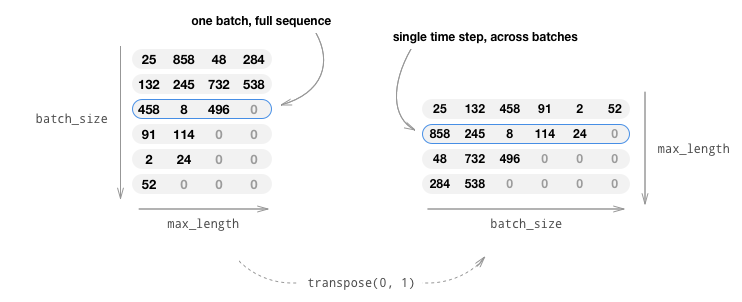

In [216]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [217]:
# test function
print(pairs[2][1])
indexesFromSentence(voc, pairs[2][1])

you re sweet.


[41846, 41847, 41866, 2]

In [218]:
inp = []
out = []
for pair in pairs[:10]:
    inp.append(pair[0])
    out.append(pair[1])
print(inp)
print(len(inp))
indexes = [indexesFromSentence(voc, sentence) for sentence in inp]
indexes

['that s because it s such a nice one.', 'there.', 'you have my word. as a gentleman', 'hi.', 'have fun tonight?', 'well no...', 'then that s all you had to say.', 'but', 'do you listen to this crap?', 'what good stuff?']
10


[[41851, 41852, 41853, 41854, 41852, 41855, 41830, 41856, 41857, 2],
 [41860, 2],
 [41846, 41862, 41842, 41863, 41864, 41830, 41865, 2],
 [41867, 2],
 [41862, 41880, 41881, 2],
 [41883, 41884, 2],
 [41885, 41851, 41852, 41886, 41846, 41887, 41888, 41889, 2],
 [41890, 2],
 [41894, 41846, 41895, 41888, 41840, 41896, 2],
 [41834, 41897, 41898, 2]]

In [350]:
# I seem to be getting 41800+ for all indexes, but I'll roll with it...?
# hopefully not a problem since it's just indexes

In [220]:
# We should arrange by decreasing length, and fill zeros
def zeroPadding(l, fillvalue=0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [221]:
leng = [len(ind) for ind in indexes]
max(leng)

10

In [222]:
test_result = zeroPadding(indexes)
print(len(test_result))
test_result

10


[(41851, 41860, 41846, 41867, 41862, 41883, 41885, 41890, 41894, 41834),
 (41852, 2, 41862, 2, 41880, 41884, 41851, 2, 41846, 41897),
 (41853, 0, 41842, 0, 41881, 2, 41852, 0, 41895, 41898),
 (41854, 0, 41863, 0, 2, 0, 41886, 0, 41888, 2),
 (41852, 0, 41864, 0, 0, 0, 41846, 0, 41840, 0),
 (41855, 0, 41830, 0, 0, 0, 41887, 0, 41896, 0),
 (41830, 0, 41865, 0, 0, 0, 41888, 0, 2, 0),
 (41856, 0, 2, 0, 0, 0, 41889, 0, 0, 0),
 (41857, 0, 0, 0, 0, 0, 2, 0, 0, 0),
 (2, 0, 0, 0, 0, 0, 0, 0, 0, 0)]

In [223]:
# Convert index tensor to binary matrix
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token in seq:
                if token == PAD_token:
                    m[i].append(0)
                else:
                    m[i].append(1)
    return m

In [224]:
binary_result = binaryMatrix(test_result)
binary_result

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
 [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
 [1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [225]:
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

In [226]:
def ouputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

In [227]:
# Batch to train returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    # sort the questions in descending length
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    #
    output, mask, max_target_len = ouputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [228]:
# Let's test that code

small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print('input variable: ')
print(input_variable)
print('lengths: ', lengths)
print('target_variable: ')
print(target_variable)
print('mask: ')
print(mask)
print('max_target_len: ')
print(max_target_len)

input variable: 
tensor([[42105, 42036, 41835, 43405, 42699],
        [41955, 42350, 42853, 41846, 42218],
        [42282, 41841, 41826, 42093,     2],
        [41870, 41830, 42072, 41850,     0],
        [42237, 46406, 41835, 50334,     0],
        [53085, 43239, 41991, 44584,     0],
        [41872, 41888,     2,     2,     0],
        [41860, 46699,     0,     0,     0],
        [    2,     2,     0,     0,     0]])
lengths:  tensor([9, 9, 7, 7, 3])
target_variable: 
tensor([[41869, 44884, 42004, 42072, 42998],
        [41965,     2, 47056, 42066, 41835],
        [    2,     0, 42364, 43405, 41978],
        [    0,     0, 43425, 41846, 54256],
        [    0,     0, 41850, 42764, 42310],
        [    0,     0, 52457,     2, 42122],
        [    0,     0,     2,     0,     2]])
mask: 
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 0, 1]], dtype=torch.uint8)
max_tar

## Part 3: Defining the Models

This is a seq2seq model. We use 2 RNN's to achieve this model, one acts as an encoder, which stores historical data, then passes the encoder state to the decoder RNN, which creates the predictions

In [229]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size # how many hidden neurons
        self.embedding = embedding
        # Initialize GRU
        # input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # input seq: batch of input sentences; shape-(max_length, batch_size)
        # input_lengths: list of sentence lengths corresponding to each sentence in the batch
        # hidden state has shape: (n_layers x num_directions, batch_size, hidden_size)
        # convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # pach padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # sum bidirectional GRU outputs
        outputs = outputs[:,:,:self.hidden_size] + outputs[:,:,self.hidden_size:]
        # return output and final hidden state
        return outputs, hidden       
        # outputs = output features from last layer of GRU
        # outputs shape = (max_length, batch_size, hidden_size)
        # hidden: hidden state for the last timestep, of shape=(n_layers x num_directions, batch_size, hidden_size) 

### Define Decoder

The decoder uses an attention layer in order to predict. The attention layer is simply a multiplication of the hidden states and the encoder outputs.

The attention mechanism receives encoder output ([max_length, batch_size, hidden_size]) and the output of a GRU, ([1, batch_size, hidden_size]). the 1 in GRU size is because we are using only 1 GRU at a time

This picture is a great representation of the dataflow, including the size of each tensor as it passes from one structure to another:

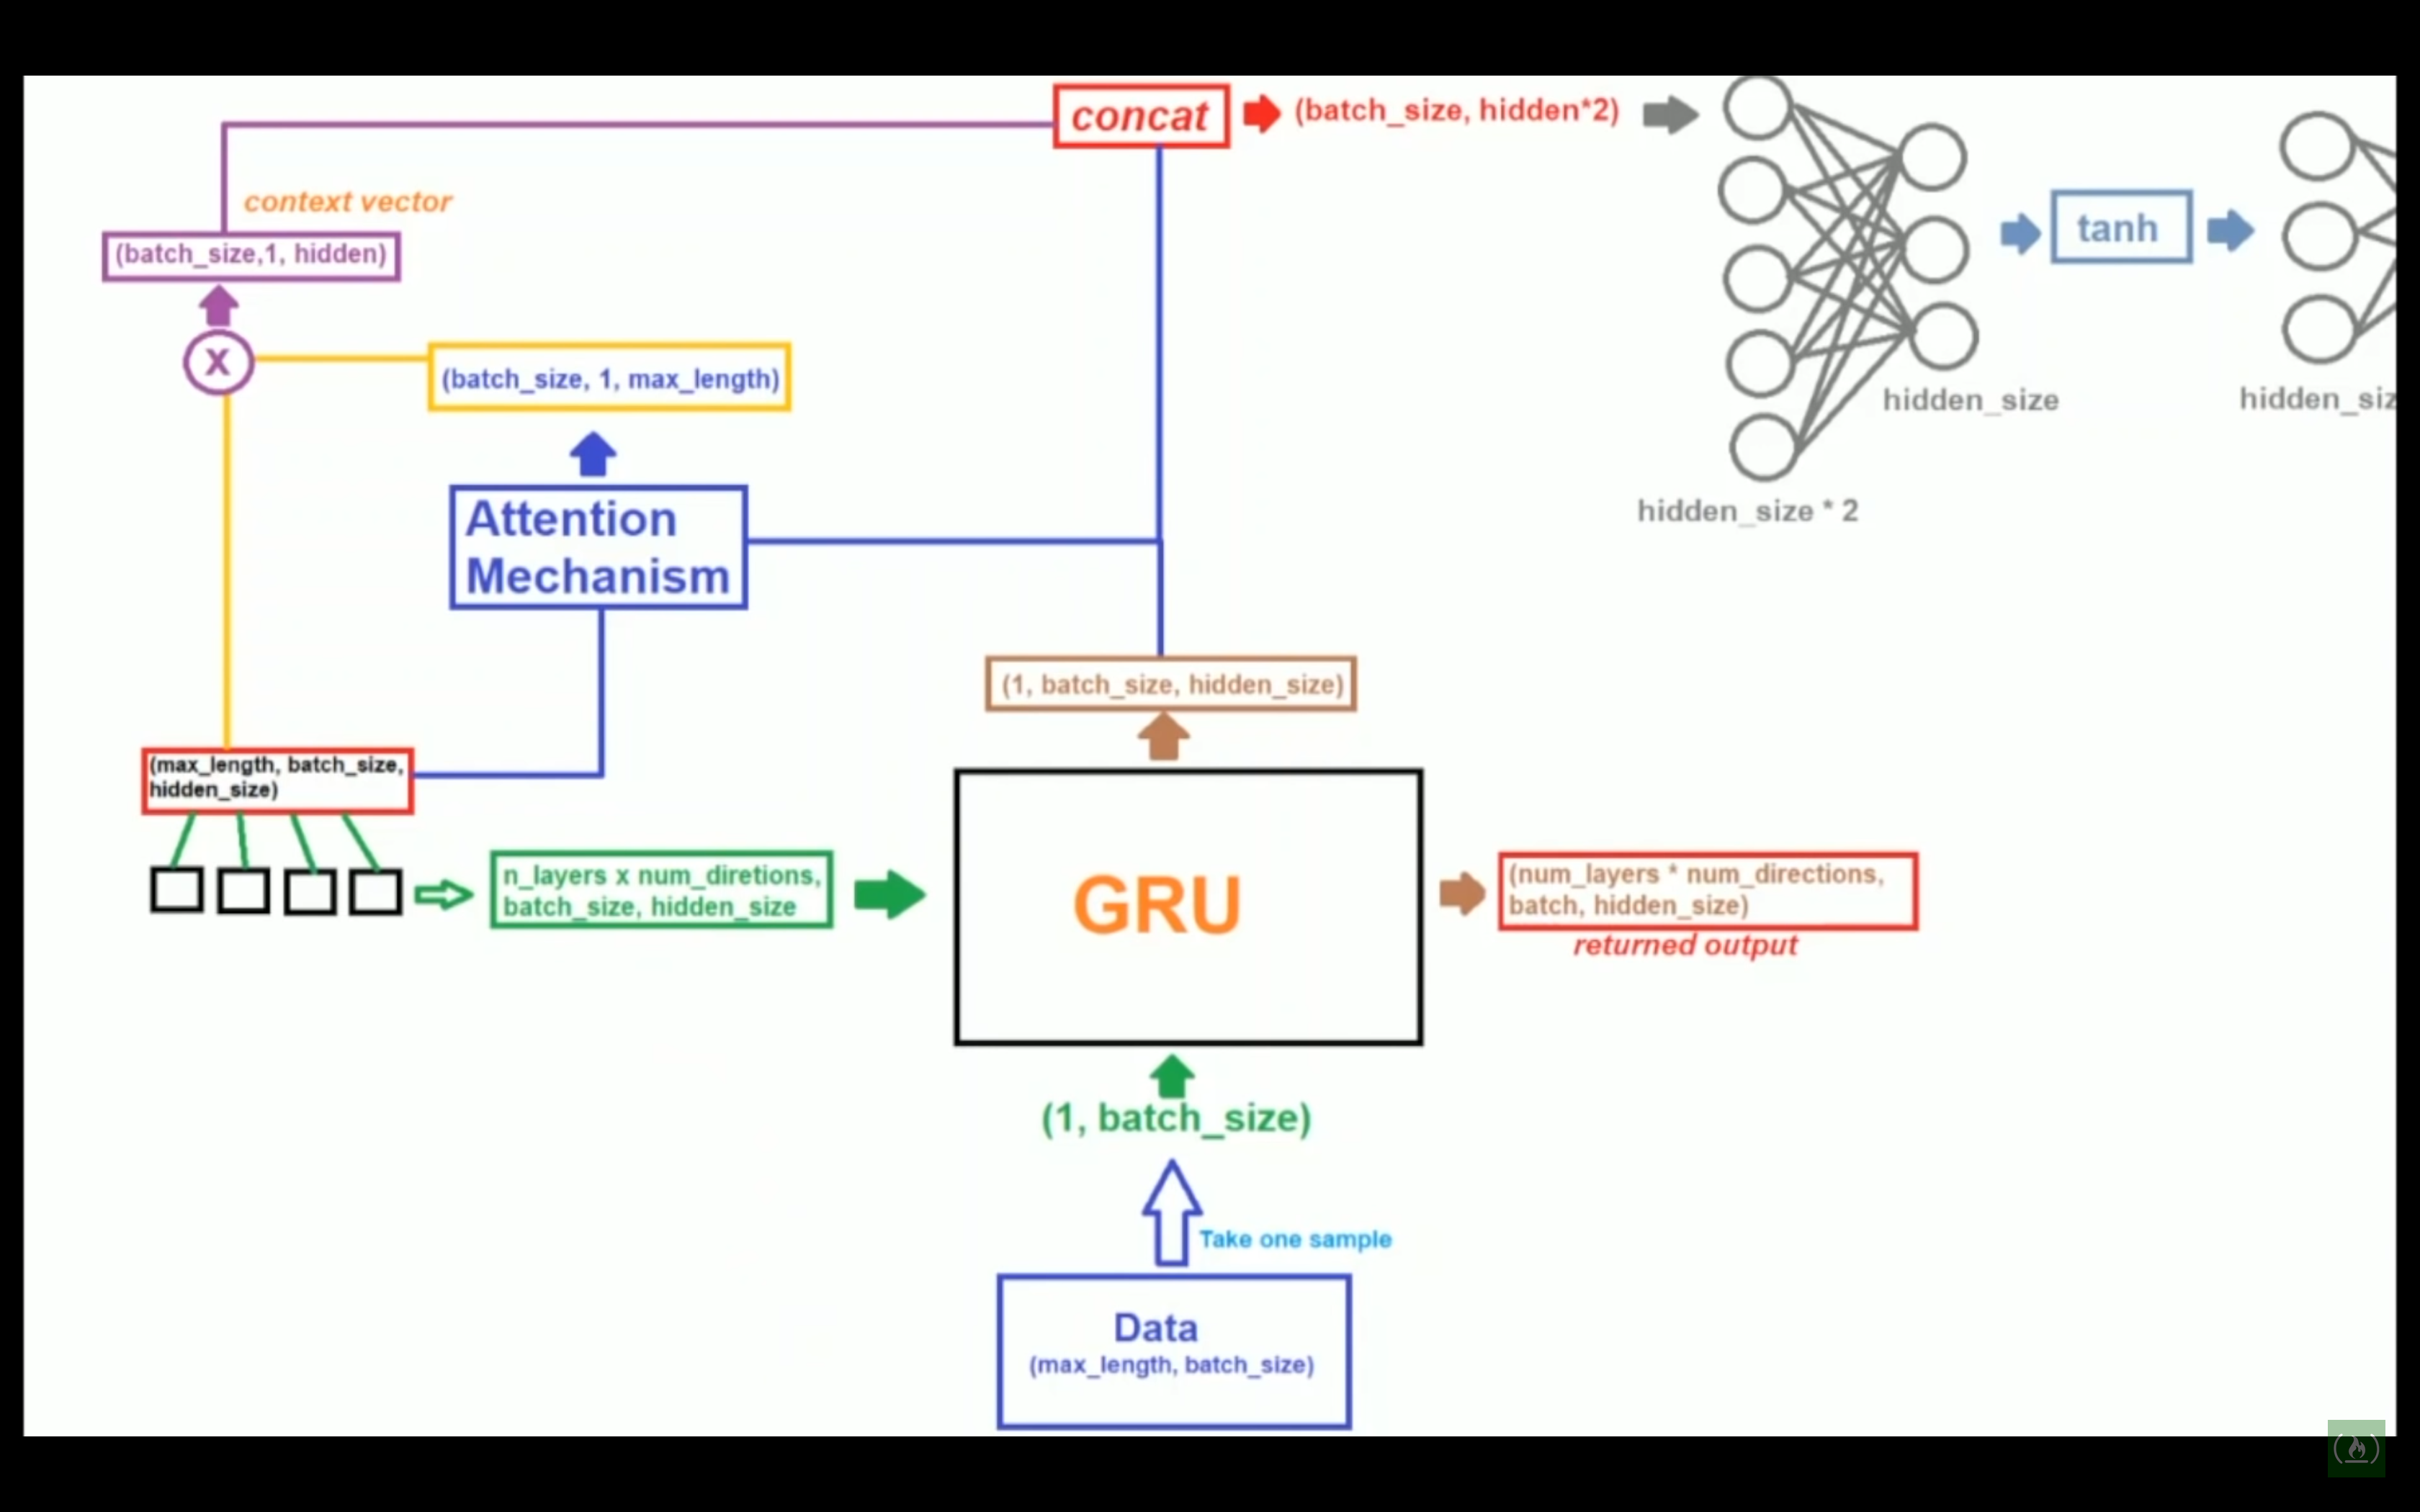

credit to freeCodeCamp.org's Fawaz Sammani for this diagram

In [230]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        # element wise multiplication of the current target devoder state with the encoder output and sum
        return torch.sum(hidden * encoder_output, dim=2)
    
    def forward(self, hidden, encoder_outputs):
        # hidden shape: (1, batch_size, hidden_size)
        # encoder_outputs shape: (max_length, batch_size, hidden_size)
        
        # calculate the attention weights (energies)
        attn_energies = self.dot_score(hidden, encoder_outputs)
        # transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()
        # return softmax normalized probability scores with additional dimension
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # unsqueeze will insert another dimension

In [231]:
# Now time for the decoder class
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, droput=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout # neurons ignore if dependency is super low / non-influential
        
        #define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        self.attn = Attn(attn_model, hidden_size)
        
    def forward(self, input_step, last_hidden, encoder_outputs):
        # forward propogation
        # input_step: one time step (one batch) of input sequence batch, shape is (1, batch_size)
        # last hidden: last hidden state of GRU; (n_layers x num_directions, batch_size, hidden_size)
        # encoder outputs: encoder model's output; (seq_len, batch, num_directions * hidden_size)
        
        # get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # rnn output shape: (1, batch, num_directions * hidden_size)
        # hidden shape: (num_layers * num_directions, batch, hidden_size)
        
        # calculate attention weights from current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # multiply attention weights to encoder outputs to get new weighted sum context vector
        # (batch_size, 1, max_length) x 
        context = attn_weights.bmm(encoder_outputs.transpose(0,1))
        #concatenate weighted context vector and GRU output
        rnn_output = rnn_output.squeeze(0)
        context = rnn_output.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # return output and final hidden state
        return output, hidden
        # :D

## Part 4: Train and Run the Model



### Training & Teacher Forcing

Teacher forcing is when we supply the inputs regardless of the last word generated. No teacher forcing is when we supply the inputs depending on the output of the previous timestep. There are advantages of both so we will use 50% teacher forcing and 50% without

### These are the steps for training our model:

1. forward pass entire input batch through encoder
2. Initialize devoder inputs as SOS_token, and hidden state as the encoder's final hidden state
3. Forward input batch sequence through decoder one time step at a time
4. If teacher forcing: set next decoder input as the current target; else: set next devoder input as the current decoder output
5. calculate and acucmulate loss
6. perform back propagation
7. clip gradients
8. update encoder and decoder model parameters

In [232]:
# The loss is how we calculate how to train the model
# NLL Loss stands for negative logistic likelihood loss
def maskNLLLoss(decoder_out, target, mask):
    nTotal = mask.sum() # How many elements should we consider?
    target = target.view(-1, 1)
    # devoder_out shape: (batch_size, vocab_size), target size: (batch_size, 1)
    gathered_tensor = torch.gather(decoder_out, 1, target)
    # calculate negative log likelihood loss (NLL Loss)
    crossEntropy = -torch.log(gathered_tensor)
    # select the non-zero elements
    loss = crossEntropy.masked_select(mask)
    # calculate mean of the loss
    loss = loss.mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [233]:
# Just to visualize what's happening again, here's the example:
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print('input variable: ')
print(input_variable)
print('lengths: ', lengths)
print('target_variable: ')
print(target_variable)
print('mask: ')
print(mask)
print('max_target_len: ')
print(max_target_len)

input variable: 
tensor([[41834, 42701, 41834, 46533, 43268],
        [41914, 41846, 41955, 42269,     2],
        [41846, 42554, 41846, 44349,     0],
        [41894, 44660, 42115,     2,     0],
        [43162, 42215, 55748,     0,     0],
        [55441,     2,     2,     0,     0],
        [    2,     0,     0,     0,     0]])
lengths:  tensor([7, 6, 6, 4, 2])
target_variable: 
tensor([[41846, 44929, 41846, 43969, 41835],
        [41942, 41846, 41875,     2, 52363],
        [41943, 41921, 41834,     0,     2],
        [43606, 43650, 41835,     0,     0],
        [    2,     2, 41978,     0,     0],
        [    0,     0, 42115,     0,     0],
        [    0,     0, 55748,     0,     0],
        [    0,     0,     2,     0,     0]])
mask: 
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]], dtype=torch.uint8)
max_target_len: 
8


In [234]:
#define parameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
attn_model = 'dot'
embedding = nn.Embedding(voc.num_words, hidden_size)

In [235]:
# Define encoder and decoder
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder.to(device)

# Set encoder and decoder to training mode
encoder.train()
decoder.train()

LuongAttnDecoderRNN(
  (embedding): Embedding(56473, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=56473, bias=True)
  (attn): Attn()
)

In [236]:
lengths

tensor([7, 6, 6, 4, 2])

In [237]:
# Initialize optimizers
# the optim is from torch, and Adam is the most commonly used optimizer
# lr is the learning rate
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_variable = input_variable.to(device)
lengths = lengths.to(device)
target_variable = target_variable.to(device)
mask = mask.to(device)

loss = 0
print_losses = []
n_totals = 0

# Call the encoder forward function using our input variables
encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
print("Encoder Ouputs Shape: ", encoder_outputs.shape)
print("Last encoder hidden shape: ", encoder_hidden.shape)

# Now, Decoder
decoder_input = torch.LongTensor([[SOS_token for _ in range(small_batch_size)]])
decoder_input = decoder_input.to(device)
print("Initial Decoder Input Shape: ", decoder_input.shape)
print(decoder_input)

# Set initial decoder hidden state to final encoder hidden state
decoder_hidden = encoder_hidden[:decoder.n_layers]
print("Initial decoder hidden state shape: ", decoder_hidden.shape)
print("\n!!!\nNow let's look at what's happening every timestep of GRU\n!!!\n")


Encoder Ouputs Shape:  torch.Size([7, 5, 500])
Last encoder hidden shape:  torch.Size([4, 5, 500])
Initial Decoder Input Shape:  torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]])
Initial decoder hidden state shape:  torch.Size([2, 5, 500])

!!!
Now let's look at what's happening every timestep of GRU
!!!



In [238]:
# Assume we are using teacher forcing
for t in range(max_target_len):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
    print("Decoder Output Shape: ", decoder_output.shape)
    print("Decoder Hidden Shape: ", decoder_hidden.shape)
    # Teacher forcing: next input is current target
    # Change the shape -> flip target variable
    decoder_input = target_variable[t].view(1,-1)
    print("Target variable: ", target_variable[t])
    print("Target shape: ", target_variable[t].shape)
    print("input shape after reshaping: ", decoder_input.shape)
    # calculate and accumulate loss
    print("The mask at the current timestep: ", mask[t])
    print("The mask at the current timestep shape: ", mask[t].shape)
    # Use masked negative log likelihood calculator to get losses
    mask_loss, nTotal, = maskNLLLoss(decoder_output, target_variable[t], mask[t])
    print("Mask Loss: ", mask_loss)
    print("Total: ", nTotal)
    # Accumulate losses
    loss += mask_loss
    print_losses.append(mask_loss.item() * nTotal)
    print(print_losses)
    n_totals += nTotal
    print(n_totals)
    encoder_optimizer.step()
    decoder_optimizer.step()
    returned_loss = sum(print_losses) / n_totals
    print("Returned loss: ", returned_loss)
    print("\n-------------- Done One Timestep ----------------\n")

Decoder Output Shape:  torch.Size([5, 56473])
Decoder Hidden Shape:  torch.Size([2, 5, 500])
Target variable:  tensor([41846, 44929, 41846, 43969, 41835])
Target shape:  torch.Size([5])
input shape after reshaping:  torch.Size([1, 5])
The mask at the current timestep:  tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
The mask at the current timestep shape:  torch.Size([5])
Mask Loss:  tensor(10.9664, grad_fn=<MeanBackward1>)
Total:  5
[54.83193397521973]
5
Returned loss:  10.966386795043945

-------------- Done One Timestep ----------------

Decoder Output Shape:  torch.Size([5, 56473])
Decoder Hidden Shape:  torch.Size([2, 5, 500])
Target variable:  tensor([41942, 41846, 41875,     2, 52363])
Target shape:  torch.Size([5])
input shape after reshaping:  torch.Size([1, 5])
The mask at the current timestep:  tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
The mask at the current timestep shape:  torch.Size([5])
Mask Loss:  tensor(10.9588, grad_fn=<MeanBackward1>)
Total:  5
[54.83193397521973, 54.79

In [330]:
# now that we've visualized what's happening, let's create a function to train the model
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0

    # Call the encoder forward function using our input variables
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
    #print("Encoder Ouputs Shape: ", encoder_outputs.shape)
    #print("Last encoder hidden shape: ", encoder_hidden.shape)

    # Now, Decoder
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    #print("Initial Decoder Input Shape: ", decoder_input.shape)
    #print(decoder_input)

    # Set initial decoder hidden state to final encoder hidden state
    #print(decoder.n_layers)
    #print(encoder_outputs.shape)
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    #print(decoder_hidden.shape)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Teacher forcing: next input is current target
            # Change the shape -> flip target variable
            decoder_input = target_variable[t].view(1,-1)
            # calculate and accumulate loss
            # Use masked negative log likelihood calculator to get losses
            mask_loss, nTotal, = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            # Accumulate losses
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Teacher forcing: next input is current target
            # Change the shape -> flip target variable
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in tange(batch_size)]])
            decoder_input.to(device)
            # calculate and accumulate loss
            # Use masked negative log likelihood calculator to get losses
            mask_loss, nTotal, = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            # Accumulate losses
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    
    # Perform back propogation
    loss.backward()
    
    # clip gradients: gradients are modified in place
    # Prevents gradient exploding
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    # adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    returned_loss = sum(print_losses) / n_totals
    return returned_loss

In [331]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, slip, corpus_name, loadFilename):
    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_iteration)]
    
    # Initialization
    print("initializing...")
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1
        
    # training loop
    print('training....')
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        
        # print progress
        if iteration % print_every ==0:
            print_loss_avg = print_loss / print_every
            print("iteration: {}; Percent Complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            
        # Save checkpoint
        if iteration % save_every == 0:
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}-{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding':embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [353]:
# Now we want to talk to the bot ourselves
# We will use Greedy decoding -> rather than calculating loss, we
# simply grab the word associated with the decoded output

# this wil look a lot like the decoder model
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, input_seq, input_length, max_length):
        # forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # initialize decoder input with SOS_token
        decoder_input = torch.ones(1,1, device=device, dtype=torch.long) * SOS_token
        # initialize tensors to append to decoded words to
        all_tokens = torch.zeros([0], device = device, dtype=torch.long)
        all_scores = torch.zeros([0], device = device)
        # iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder, concatenating outputs of softmax
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # return the tokens (words) and scores (likelihood)
        return all_tokens, all_scores

In [356]:
# Now we set up a translator for token -> word

def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    # format input sentence as a batch
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # decode sntence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

# Out infinite loop for user input
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            input_sentence = input('> ')
            # check for quit case
            if input_sentence == 'quit' or input_sentence == 'q': break
            input_sentence = normalizeString(input_sentence)
            # evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # format and print response
            output_words[:] = [x for x in output_words if not (x=='EOS' or x == 'PAD')]
            print('BOT: ', ' '.join(output_words))
            
        except KeyError:
            print("Error: encountered unknown word.")

### Latsly, time to run the model

Step 1: Create the model
Step 2: Train the model
Step 3: Run the model

In [348]:
# Step 1: create model

# Configure model
model_name = 'cb_model'
attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from, None if starting from scratch
loadFilename = None
checkpoint_iter = 4000

# LoadFile
loadFileName = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size), '{}_checkpoint.tar'.format(checkpoint_iter))

if loadFilename:
    checkpoint = torch.load(loadFilename)
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

print("building encoder and decoder...")
# initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# initialize encoder and decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')


building encoder and decoder...
Models built and ready to go!


In [336]:
save_dir = os.path.join("data", "save")
corpus_name = "cornell movie-dialogs corpus"

In [349]:
# Step 2: training

# configure training / optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 1500
print_every = 4
save_every = 500

#ensure dropout layers are in train mode
encoder.train()
decoder.train()

print('building optimizers...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)
# run training iterations
print("start training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename)


building optimizers...
start training!
initializing...
training....
iteration: 4; Percent Complete: 0.3%; Average loss: 10.4130
iteration: 8; Percent Complete: 0.5%; Average loss: 8.1780
iteration: 12; Percent Complete: 0.8%; Average loss: 7.5716
iteration: 16; Percent Complete: 1.1%; Average loss: 6.7225
iteration: 20; Percent Complete: 1.3%; Average loss: 5.7441
iteration: 24; Percent Complete: 1.6%; Average loss: 5.4311
iteration: 28; Percent Complete: 1.9%; Average loss: 5.1464
iteration: 32; Percent Complete: 2.1%; Average loss: 4.7949
iteration: 36; Percent Complete: 2.4%; Average loss: 4.8797
iteration: 40; Percent Complete: 2.7%; Average loss: 4.6146
iteration: 44; Percent Complete: 2.9%; Average loss: 4.7756
iteration: 48; Percent Complete: 3.2%; Average loss: 4.7954
iteration: 52; Percent Complete: 3.5%; Average loss: 4.4629
iteration: 56; Percent Complete: 3.7%; Average loss: 4.6016
iteration: 60; Percent Complete: 4.0%; Average loss: 4.5781
iteration: 64; Percent Complete: 

iteration: 536; Percent Complete: 35.7%; Average loss: 3.4891
iteration: 540; Percent Complete: 36.0%; Average loss: 3.6301
iteration: 544; Percent Complete: 36.3%; Average loss: 3.5786
iteration: 548; Percent Complete: 36.5%; Average loss: 3.6632
iteration: 552; Percent Complete: 36.8%; Average loss: 3.7176
iteration: 556; Percent Complete: 37.1%; Average loss: 3.6679
iteration: 560; Percent Complete: 37.3%; Average loss: 3.5774
iteration: 564; Percent Complete: 37.6%; Average loss: 3.6031
iteration: 568; Percent Complete: 37.9%; Average loss: 3.6052
iteration: 572; Percent Complete: 38.1%; Average loss: 3.7198
iteration: 576; Percent Complete: 38.4%; Average loss: 3.6221
iteration: 580; Percent Complete: 38.7%; Average loss: 3.5683
iteration: 584; Percent Complete: 38.9%; Average loss: 3.6007
iteration: 588; Percent Complete: 39.2%; Average loss: 3.5106
iteration: 592; Percent Complete: 39.5%; Average loss: 3.6534
iteration: 596; Percent Complete: 39.7%; Average loss: 3.6623
iteratio

iteration: 1064; Percent Complete: 70.9%; Average loss: 3.4149
iteration: 1068; Percent Complete: 71.2%; Average loss: 3.4064
iteration: 1072; Percent Complete: 71.5%; Average loss: 3.3786
iteration: 1076; Percent Complete: 71.7%; Average loss: 3.3045
iteration: 1080; Percent Complete: 72.0%; Average loss: 3.3421
iteration: 1084; Percent Complete: 72.3%; Average loss: 3.2065
iteration: 1088; Percent Complete: 72.5%; Average loss: 3.2291
iteration: 1092; Percent Complete: 72.8%; Average loss: 3.3499
iteration: 1096; Percent Complete: 73.1%; Average loss: 3.3519
iteration: 1100; Percent Complete: 73.3%; Average loss: 3.1352
iteration: 1104; Percent Complete: 73.6%; Average loss: 3.2298
iteration: 1108; Percent Complete: 73.9%; Average loss: 3.2934
iteration: 1112; Percent Complete: 74.1%; Average loss: 3.1924
iteration: 1116; Percent Complete: 74.4%; Average loss: 3.4363
iteration: 1120; Percent Complete: 74.7%; Average loss: 3.3523
iteration: 1124; Percent Complete: 74.9%; Average loss:

In [357]:
# Step 3: Run evaluation

# set dropout layers to eval mode
encoder.eval()
decoder.eval()

# initialize search module to the greedy search decoder
searcher = GreedySearchDecoder(encoder, decoder)

In [360]:
# Talk to the bot:
evaluateInput(encoder, decoder, searcher, voc)

> Say something!
BOT:  i m not going to see you.
> Say something else!
Error: encountered unknown word.
> else!
Error: encountered unknown word.
> else
BOT:  i m not going to see you.
> say something else
BOT:  i m not going to see you.
> ok
BOT:  i m not going to see you.
> how was your day?
BOT:  i don t know what i m saying.
> I know, that's ok buddy
BOT:  i don t know what i m saying.
> don't beat yourself up kid
BOT:  i don t know what i m saying.
> alright
BOT:  i m not going to see you.
> want some ice cream?
BOT:  i don t know what i m saying.
> ice cream
BOT:  i don t know what i m saying.
> ice
BOT:  i don t know what i m saying.
> cream
BOT:  i m not going to see you.
> .... jeez
BOT:  i m not going to see you.
> ok
BOT:  i m not going to see you.
> well
BOT:  i m not going to talk to you.
> time to train you some more again
BOT:  i m not going to see you.
> ... yep
BOT:  i m not going to see you.
> q


## Final Thoughts

2/26/2019 5:15PM: I made a chatbot! While it's not always totally coherent, I'm happy with how it turned out. There are a few things to fix, definitely going to increase the n_iterations variable from 1500 up to 4000 or so, but I am glad to see that there are no errors! 